# Simulation of Moon TOD using real scan data

In [6]:
%config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# rc('figure',figsize=(20,12))
# rc('font',size=12)

from datetime import datetime
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
# plt.style.use(astropy_mpl_style)
quantity_support()
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_moon, get_sun, get_body

Salta = EarthLocation(lat=-24.731375*u.deg, lon=-65.409551*u.deg, height=1152*u.m)
####utcoffset = -3*u.hour  # Eastern Daylight Time

from scipy.signal import medfilt
from scipy.interpolate import interp1d
import glob
import gc

from qubicpack.qubicfp import qubicfp
import qubic.lib.Calibration.Qfiber as ft
import qubic
import healpy as hp
from qubicpack.utilities import Qubic_DataDir

from importlib import reload
import healpy as hp

import time_domain_tools as tdt





Let's first read some QUBIC TOD in order to get the azimuth/elevation. We take the data for the Moon scan taken on 14/07/2022.
The zero azimuth for QUBIC that day was: azqubic = 116.4

ASIC1     Observation date: 2022-07-14 23:54:19.113000
ASIC1 Observation end date: 2022-07-15 03:26:02.320000
ASIC2     Observation date: 2022-07-14 23:54:19.113000
ASIC2 Observation end date: 2022-07-15 03:26:02.320000
No raw data found in directory: /users/hamilton/Qubic/Data/CommissioningTD//2022-07-14/2022-07-14_23.54.19__MoonScan_Speed_VE14/Raws
No calsource data found in directory: /users/hamilton/Qubic/Data/CommissioningTD//2022-07-14/2022-07-14_23.54.19__MoonScan_Speed_VE14/Hks
No calsource data found in directory: /users/hamilton/Qubic/Data/CommissioningTD/calsource
No hornswitch data found in directory: /users/hamilton/Qubic/Data/CommissioningTD/hornswitch
Please give a valid asic number
No previously saved filter information: QUBIC_TES_ASIC1_20220714T235419UTC.filter.pickle
No previously saved filter information: QUBIC_TES_ASIC2_20220714T235419UTC.filter.pickle
No PPS in MMR_HK
No PPS.  Using computer time instead
TES temperature varies between 317.6mK and 320.1mK during the

Text(0, 0.5, 'el')

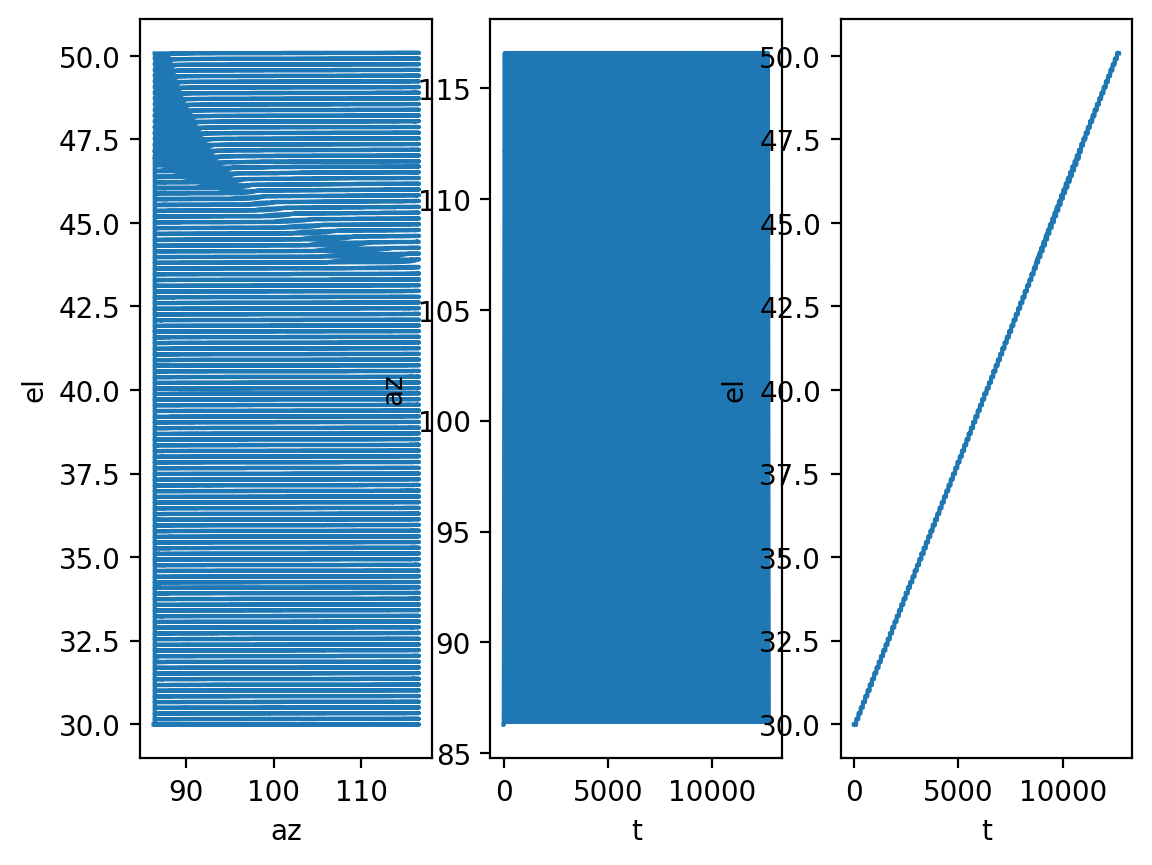

In [11]:
mydatadir = '/users/hamilton/Qubic/Data/CommissioningTD/'
# mydatadir = '/Volumes/HD JCH SSD/Qubic/QubicData/Calib-TD/'
thedate = '2022-07-14'
thedirs = glob.glob(mydatadir + '/' + thedate + '/*')
thedata = thedirs[0]
azqubic = 116.4


### Read data
a = qubicfp()
a.read_qubicstudio_dataset(thedata)

### We don;t need to fill the memory with the TODs
#tt, alltod = a.tod()

az = a.azimuth() + azqubic
el = a.elevation()
thk = a.timeaxis(datatype='hk')

#del(a)

### We remove tt[0]
tinit = thk[0]
thk -= tinit

# rc('figure',figsize=(20,8))
# rc('font',size=12)
plt.subplot(1,3,1)
plt.plot(az, el)
plt.xlabel('az')
plt.ylabel('el')

plt.subplot(1,3,2)
plt.plot(thk, az)
plt.xlabel('t')
plt.ylabel('az')

plt.subplot(1,3,3)
plt.plot(thk, el)
plt.xlabel('t')
plt.ylabel('el')


In [12]:
del(a)
gc.collect() 

800

In [14]:
### Create a QubicSampling object from these
from qubic.lib.Qsamplings import QubicSampling

### Don;t forget the UTC offset
####utcoffset = 3.

date_obs = str(datetime.utcfromtimestamp(tinit))
print('Observations started at: {} UTC'.format(date_obs))

qs = QubicSampling(azimuth=az, elevation=el, time=thk,
                   #period=np.median(thk[1:]-thk[:-1]), 
                   date_obs=date_obs, longitude=float(Salta.lon/u.deg), latitude = float(Salta.lat/u.deg))

Observations started at: 2022-07-14 23:54:17 UTC


In [ ]:
%matplotlib inline
plt.plot(qs.time, qs.equatorial[:,0])
xlabel('UTC Time from QS (sec)')
ylabel('RA from QS (deg)')
subplot(2,3,2)
plot(qs.time , qs.equatorial[:,1])
xlabel('UTC Time from QS (sec)')
ylabel('DEC from QS (deg)')
subplot(2,3,3)
plot(qs.equatorial[:,0], qs.equatorial[:,1])
xlabel('RA from QS (deg)')
ylabel('DEC from QS (deg)')
tight_layout()

subplot(2,3,4)
plot(qs.azimuth, qs.elevation, label='From QS')
plot(az, el, '--', label='From HK')
xlabel('az (deg)')
ylabel('el (deg)')

subplot(2,3,5)
plot(qs.time, qs.azimuth, label='From QS')
plot(thk, az, '--', label='From HK')
xlabel('time (sec)')
ylabel('az (deg)')

subplot(2,3,6)
plot(qs.time, qs.elevation, label='From QS')
plot(thk, el, '--', label='From HK')
xlabel('time (sec)')
ylabel('el (deg)')


We now need the coordinates of the Moon at these very same time samples. We use astropy for that purpose.

In [ ]:

alltimes = Time(date_obs) + thk*u.second #+ 3*u.minute

############################### Using Astropy #########################
### Local coordinates
frame_Salta = AltAz(obstime=alltimes , location=Salta)

### Moon
moon_Salta = get_body('Moon', alltimes, Salta)

### RA/DEC
moonra = moon_Salta.ra
moondec = moon_Salta.dec

### l,b
g = SkyCoord(moon_Salta.ra, moon_Salta.dec, frame='icrs').galactic
moongal_l, moongal_b = g.l.degree, g.b.degree
# moongal_l, moongal_b = qubic.equ2gal(moonra, moondec)

moonaltazs_Salta = moon_Salta.transform_to(frame_Salta)  
myazmoon = moonaltazs_Salta.az.value
myelmoon = moonaltazs_Salta.alt.value

### Now we know the equatorial/Galactic location of the moon 
lmoon_av = np.mean(np.array(moongal_l))
bmoon_av = np.mean(np.array(moongal_b))

ramoon_av = np.mean(moonra)
decmoon_av = np.mean(moondec)
########################################################################

In [ ]:
subplot(2,2,1)
plot(qs.azimuth, qs.elevation, label='QS')
plot(myazmoon, myelmoon, 'ro', label='Astropy')
legend()
xlabel('az')
ylabel('el')

subplot(2,2,2)
plot(qs.azimuth-myazmoon, qs.elevation-myelmoon, label='QS')
plot(myazmoon - myazmoon, myelmoon-myelmoon, 'ro', label='Astropy')
legend()
xlabel('az - azmoon')
ylabel('el-elmoon')


subplot(2,2,3)
plot(qs.equatorial[:,0], qs.equatorial[:,1], label='QS')
plot(moonra, moondec, 'ro', label='Astropy')
plot(ramoon_av, decmoon_av, 'y+', ms=20, mew=3, label='Mean Astropy')
legend()
xlabel('RA (deg)')
ylabel('DEC (deg)')
tight_layout()

subplot(2,2,4)
plot(qs.galactic[:,0], qs.galactic[:,1], label='QS')
plot(moongal_l, moongal_b, 'ro', label='Astropy')
plot(lmoon_av, bmoon_av, 'y+', ms=20, mew=3, label='Mean Astropy')
legend()
xlabel('l (deg)')
ylabel('b (deg)')
tight_layout()


# Now trying to get the Moon moving
For this we need to be in a coordinate system where the Moon does not move, then perform acquisition in this system and use this TOD in the former system (that of the real data).


## method:
Calculate Moon coordinates in (RA,DEC) or (l,b) using astropy, subtract this to pointing's sky coordinates and come back to Az,el...

In [ ]:
### Shift in RA,DEC
shiftra = (moonra - np.mean(moonra))/u.deg
shiftdec = (moondec - np.mean(moondec))/u.deg
newra = (qs.equatorial[:,0] - shiftra) 
newdec = qs.equatorial[:,1] - shiftdec

newmoonra = moonra/u.deg - shiftra
newmoondec = moondec/u.deg - shiftdec

### COnvert to Gal coordinates
newl, newb = qubic.equ2gal(newra, newdec)
newmoonl, newmoonb = qubic.equ2gal(newmoonra, newmoondec)

### Now we need to got to local coordinates az,el...
altaz = SkyCoord(newra*u.deg, newdec*u.deg, frame='icrs').transform_to(frame_Salta) 
newaz = altaz.az.value
newel = altaz.alt.value
altazmoon = SkyCoord(newmoonra*u.deg, newmoondec*u.deg, frame='icrs').transform_to(frame_Salta) 
newmoonaz = altazmoon.az.value
newmoonel = altazmoon.alt.value

### New sampling
qsmoon = QubicSampling(azimuth=newaz, elevation=newel, time=qs.time,
                   date_obs=date_obs, longitude=float(Salta.lon/u.deg), latitude = float(Salta.lat/u.deg))
                       

subplot(2,3,2)
plot(qsmoon.galactic[:,0], qsmoon.galactic[:,1], label='New QSmoon')
plot(qs.galactic[:,0], qs.galactic[:,1], label='Initital QS', alpha=0.5)
plot(newmoonl, newmoonb, 'ro', label='Moon Motion')
xlabel('New l')
ylabel('New b')
legend()

subplot(2,3,1)
plot(qsmoon.equatorial[:,0], qsmoon.equatorial[:,1], label='New QSmoon')
plot(qs.equatorial[:,0], qs.equatorial[:,1], label='Initital QS', alpha=0.5)
plot(newmoonra, newmoondec, 'ro', label='Moon Motion')
xlabel('New RA')
ylabel('New DEC')
legend()


subplot(2,3,3)
plot(qsmoon.azimuth, qsmoon.elevation, label='New QSmoon')
plot(qs.azimuth, qs.elevation, label='Initital QS', alpha=0.5)
plot(newmoonaz, newmoonel, 'ro', label='Moon Motion')
xlabel('New az')
ylabel('New el')
legend()


In [ ]:
subplot(1,3,1)
plot(qsmoon.azimuth, qsmoon.elevation, label='QSmoon')
plot(newmoonaz, newmoonel, 'ro', label='Moon Motion')
xlabel('(az - az_moon)')
ylabel('el - el_moon')
legend()

subplot(1,3,2)
plot(qsmoon.equatorial[:,0], qsmoon.equatorial[:,1], label='QSmoon')
plot(newmoonra, newmoondec, 'ro', label='Moon Motion')
xlabel('RA From Moon')
ylabel('DEC From Moon')
legend()

subplot(1,3,3)
plot(qsmoon.galactic[:,0], qsmoon.galactic[:,1], label='QSmoon')
plot(newmoonl, newmoonb, 'ro', label='Moon Motion')
xlabel('Gal l From Moon')
ylabel('Gal b From Moon')
legend()


In [ ]:
### Now we know the equatorial/Galactic location of the moon in this referential attached to the Moon. We can create an image of the moon there
nside = 256

lmoon_av = np.mean(newmoonl)  ### Mean but in fact it is constant
bmoon_av = np.mean(newmoonb)  ### Mean but in fact it is constant


print(lmoon_av, bmoon_av)
uvmoon = hp.ang2vec(np.radians(90.-bmoon_av), np.radians(lmoon_av))

allip = np.arange(12*nside**2)
pixmoon = hp.query_disc(nside, uvmoon, np.radians(0.5), inclusive=True)
map_in = np.zeros(12*nside**2)
map_in[pixmoon] = 1

hp.mollview(map_in, sub=(2,2,1))
hp.gnomview(map_in, rot=[lmoon_av, bmoon_av], reso=10, sub=(2,2,2))

### We can calculate the coverage from the l,b of th epointing and display it
ipcov = hp.ang2pix(nside, np.radians(90.-qsmoon.galactic[:,1]), np.radians(qsmoon.galactic[:,0]))
mapcov = map_in.copy()
mapcov[ipcov] += 1
hp.mollview(mapcov, sub=(2,2,3))
hp.gnomview(mapcov, rot=[lmoon_av, bmoon_av], reso=10, sub=(2,2,4))


In [ ]:
### Let's simulate TOD from this
# Repository for dictionary and input maps
global_dir = Qubic_DataDir(datafile='instrument.py', datadir='../')
dictfilename = global_dir + '/dicts/pipeline_MoonSalta.dict'
d = qubic.qubicdict.qubicDict()
d.read_from_file(dictfilename)
d['nside'] = 256
d['config'] = 'TD'
d['kind'] = 'I'
d['nf_sub'] = 5
d['nf_recon'] = 2
d['MultiBand'] = True
d['sweeping_pointing_deadtime'] = False
d['noiseless'] = True

d['detector_tau'] = 0.01

s = qubic.QubicScene(d)
q = qubic.QubicMultibandInstrument(d)

_, nus_edge_in, nus_in, _, _, _ = qubic.compute_freq(d['filter_nu'] / 1e9, d['nf_sub'],
                                                d['filter_relative_bandwidth'])

# Create an input map with the moon in each sub-frequency
y0 = np.empty((d['nf_sub'], 12 * d['nside'] ** 2))
for i in range(d['nf_sub']):
    y0[i,:] = map_in * (150/nus_in[i])**4


### We use our fake moon-frame pointing qsmoon
qsmoon.fix_az = False
a = qubic.QubicMultibandAcquisition(q, qsmoon, s, d, nus_edge_in)

TOD, mapconv = a.get_observation(y0, noiseless=d['noiseless'], convolution = True)
del a
gc.collect()   ### Important ! Frees the meory

In [ ]:
plot(thk, TOD[0,:])

In [ ]:
def healpix_map(azt, elt, tod, flags=None, flaglimit=0, nside=128, countcut=0, unseen_val=hp.UNSEEN):
    if flags is None:
        flags = np.zeros(len(azt))
    
    ok = flags <= flaglimit 
    return healpix_map_(azt[ok], elt[ok], tod[ok], nside=nside, countcut=countcut, unseen_val=unseen_val)


def healpix_map_(azt, elt, tod, nside=128, countcut=0, unseen_val=hp.UNSEEN):
    ips = hp.ang2pix(nside, azt, elt, lonlat=True)
    mymap = np.zeros(12*nside**2)
    mapcount = np.zeros(12*nside**2)
    for i in range(len(azt)):
        mymap[ips[i]] += tod[i]
        mapcount[ips[i]] += 1
    unseen = mapcount <= countcut
    mymap[unseen] = unseen_val
    mapcount[unseen] = unseen_val
    mymap[~unseen] = mymap[~unseen] / mapcount[~unseen]
    return mymap, mapcount

def display_one(mapsb, anatype='', sub=(1,1,1), nlo=3, nhi=3, reso=12, rot=[0,50]):
    unseen = (mapsb == hp.UNSEEN)
    mm, ss = ft.meancut(mapsb[~unseen], 3)
    hp.gnomview(mapsb, rot=rot, reso=reso, sub=sub, title=anatype+'\n Both scans $\sigma$ = {0:5.3g}'.format(ss), min=-nlo*ss, max=nhi*ss)


def do_display_all(mapsb, mapsb_pos, mapsb_neg, mapav, mapdiff, mapdiff2, rot=[0,50], anatype='', reso=12, myrange=None, TESNum = None):
    unseen = (mapsb == hp.UNSEEN) | (mapsb_pos == hp.UNSEEN) | (mapsb_neg == hp.UNSEEN)
    mm, ss = ft.meancut(mapsb[~unseen], 3)
    
    if myrange is None:
        mini = -3*ss
        maxi = 3*ss
    else:
        mini = myrange[0]
        maxi = myrange[1]
        
    if TESNum != None:
        anatype += '\n TES# {}'.format(TESNum)

    figure()
    hp.gnomview(mapsb, rot=rot, reso=reso, sub=(2,3,1), title=anatype+'\n Both scans $\sigma$ = {0:5.4g}'.format(ss), min=mini, max=maxi)
    mmp, ssp = ft.meancut(mapsb_pos[~unseen], 3)
    hp.gnomview(mapsb_pos, rot=rot, reso=reso, sub=(2,3,2), title=anatype+'\n Pos scans $\sigma$ = {0:5.4g}'.format(ssp), min=mini, max=maxi)
    mmn, ssn = ft.meancut(mapsb_neg[~unseen], 3)
    hp.gnomview(mapsb_neg, rot=rot, reso=reso, sub=(2,3,3), title=anatype+'\n Neg scans $\sigma$ = {0:5.4g}'.format(ssn), min=mini, max=maxi)
    mma, ssa = ft.meancut(mapav[~unseen], 3)
    hp.gnomview(mapav, rot=rot, reso=reso, sub=(2,3,4), title=anatype+'\n Av of Both scans $\sigma$ = {0:5.4g}'.format(ssa), min=mini, max=maxi)
    mmd, ssd = ft.meancut(mapdiff[~unseen], 3)
    hp.gnomview(mapdiff, rot=rot, reso=reso, sub=(2,3,5), title=anatype+'\n Diff of both scans $\sigma$ = {0:5.4g}'.format(ssd), min=mini/ss*ssd, max=maxi/ss*ssd)
    mmd2, ssd2 = ft.meancut(mapdiff2[~unseen], 3)
    hp.gnomview(mapdiff2, rot=rot, reso=reso, sub=(2,3,6), title=anatype+'\n Both - Av $\sigma$ = {0:5.4g}'.format(ssd2), min=mini/ss**ssd, max=maxi/ss*ssd)
    

def display_all(mapsb, mapsb_pos, mapsb_neg, anatype='', rot=[0,50], highcontrast=False, reso=12, myrange=None, TESNum=None):
    unseen = (mapsb == hp.UNSEEN) | (mapsb_pos == hp.UNSEEN) | (mapsb_neg == hp.UNSEEN)

    ### Average of back and Forth
    mapav = (mapsb_pos + mapsb_neg)/2
    mapav[unseen] = hp.UNSEEN

    ### Difference of back and Forth
    mapdiff = (mapsb_pos - mapsb_neg)
    mapdiff[unseen] = hp.UNSEEN

    ### Difference of All and Av
    mapdiff2 = (mapav - mapsb)
    mapdiff2[unseen] = hp.UNSEEN
    
    if highcontrast:
        myrange = [-np.max(mapsb[~unseen])/10, np.max(mapsb[~unseen])*0.8]
        
    do_display_all(mapsb, mapsb_pos, mapsb_neg, mapav, mapdiff, mapdiff2, rot=rot, anatype=anatype, reso=reso, myrange=myrange, TESNum=TESNum)
    


In [ ]:
import qubicpack as qp
# Function to go from QubicSoft (Sims) indices (0-247) to QubicPack (data) indices (0-255)
### The 8 thermometers are not in QubicSoft

def iQS2iQP(indexQS):
    qpnumi, qpasici = qp.pix2tes.pix2tes(indexQS+1)
    return qpnumi+(qpasici-1)*128-1

def iQP2iQS(indexQP):
    QStesnum = qp.pix2tes.tes2pix(indexQP%128+1, indexQP//128+1)
    return QStesnum-1


In [ ]:
from pyoperators import Cartesian2SphericalOperator
positions = q[0].detector.center
plot(positions[:,0], positions[:,1], 'ro')
q[0].detector.plot()

uvecs = positions / np.sqrt(np.sum(positions ** 2, axis=-1))[..., None]
sh = np.shape(uvecs)
ths = np.zeros(sh[0])
phs = np.zeros(sh[0])
for i in range(sh[0]):
    ths[i], phs[i] = Cartesian2SphericalOperator('zenith,azimuth')(uvecs[i,:])

figure()
subplot(1,3,1, projection="hammer")
grid()
plot(phs, np.pi/2-ths, 'k.')

rotmat = hp.Rotator(rot=[0, 90, 0], deg=True)
newths, newphs = rotmat(ths, phs)

subplot(1,3,2, projection="hammer")
grid()
plot(newphs-np.pi, np.pi/2-newths, 'k.')

subplot(1,3,3)
plot(np.degrees(newphs), np.degrees(newths), 'ro')

In [ ]:
TESNum = 96     #33->154, 96->231

indexQS = iQP2iQS(TESNum-1)

tod = TOD[indexQS,:]
speedmin = 0.05

nside = 256

###### Pipeline:
# 0. Identify scan types and numbers
scantype_hk, azt, elt, scantype = tdt.identify_scans(thk, qs.azimuth, qs.elevation, tt=qs.time, doplot=False, thr_speedmin=speedmin)
nscans = np.max(np.abs(scantype))

# # Map-making
# mapsb, mapcount = healpix_map(qs.azimuth[scantype != 0], qs.elevation[scantype != 0], tod[scantype != 0], nside=nside)

# # Display Results
# hp.gnomview(mapsb, rot=[np.mean(qs.azimuth), np.mean(qs.elevation)], reso=8, sub=(1,3,1), title='Az/El Co-added Map [QP #{} ; QS #{}]'.format(TESNum, indexQS+1))


# Map-making
azqubic = 116.4*0  ### it is already accounted for
newazt = (qs.azimuth + azqubic - np.mean(myazmoon)) * np.cos(np.radians(qs.elevation))
newelt = -(qs.elevation - np.mean(myelmoon))

# Map-making in az,el
azqubic = 116.4  ### it is already accounted for
newazt = qs.azimuth-np.mean(qs.azimuth) - (myazmoon - np.mean(myazmoon))
newelt = -(qs.elevation-np.mean(qs.elevation)) + (myelmoon - np.mean(myelmoon))


print(len(newazt))

mapsb, mapcount = healpix_map(newazt[scantype != 0], newelt[scantype != 0], tod[scantype != 0], nside=nside)

# Display Results
hp.gnomview(mapsb, reso=7, rot=[-deltaph, -deltath], sub=(1,2,1), title='Az/El wrt Moon FP centered [QP #{} ; QS #{}]'.format(TESNum, indexQS+1))


### Centered on L.O.S
dth_tes = np.degrees(np.pi/2-newths[indexQS])
dph_tes = np.degrees(newphs[indexQS]-np.pi)
hp.gnomview(mapsb, reso=7, rot=[-dph_tes , -dth_tes], sub=(1,2,2), title='L.O.S. centered [QP #{} ; QS #{}]'.format(TESNum, indexQS+1))
hp.graticule()
hp.projplot(np.radians(90),np.radians(0),'r+', mew=3, ms=10, label='FP center')
hp.projplot(np.pi-newths, -(newphs-np.pi),'r.', label='detectors')
hp.projplot(np.pi-newths[indexQS], -(newphs[indexQS]-np.pi),'go', label='QP#{}'.format(TESNum))
legend()

In [ ]:
TESNum = 96     #33->154, 96->231

indexQS = iQP2iQS(TESNum-1)

tod = TOD[indexQS,:]
speedmin = 0.05

nside = 256

###### Pipeline:
# 0. Identify scan types and numbers
scantype_hk, azt, elt, scantype = tdt.identify_scans(thk, qs.azimuth, qs.elevation, tt=qs.time, doplot=False, thr_speedmin=speedmin)
nscans = np.max(np.abs(scantype))

# # Map-making
# mapsb, mapcount = healpix_map(qs.azimuth[scantype != 0], qs.elevation[scantype != 0], tod[scantype != 0], nside=nside)

# # Display Results
# hp.gnomview(mapsb, rot=[np.mean(qs.azimuth), np.mean(qs.elevation)], reso=8, sub=(1,3,1), title='Az/El Co-added Map [QP #{} ; QS #{}]'.format(TESNum, indexQS+1))


# Map-making
azqubic = 116.4*0  ### it is already accounted for
newazt = (qs.azimuth + azqubic - myazmoon) * np.cos(np.radians(qs.elevation))
newelt = -(qs.elevation - myelmoon)

print(len(newazt))

mapsb, mapcount = healpix_map(newazt[scantype != 0], newelt[scantype != 0], tod[scantype != 0], nside=nside)

### This rotation is not understood
deltath = 0
deltaph = 0

# Display Results
hp.gnomview(mapsb, reso=7, rot=[-deltaph, -deltath], sub=(1,2,1), title='Az/El wrt Moon FP centered [QP #{} ; QS #{}]'.format(TESNum, indexQS+1))


### Centered on L.O.S
dth_tes = np.degrees(np.pi/2-newths[indexQS])
dph_tes = np.degrees(newphs[indexQS]-np.pi)
hp.gnomview(mapsb, reso=7, rot=[-deltaph-dph_tes , -deltath-dth_tes], sub=(1,2,2), title='L.O.S. centered [QP #{} ; QS #{}]'.format(TESNum, indexQS+1))
hp.graticule()
hp.projplot(np.radians(90)+np.radians(deltath),np.radians(0)+np.radians(deltaph),'r+', mew=3, ms=10, label='FP center')
hp.projplot(np.pi-newths+np.radians(deltath), -(newphs-np.pi)+np.radians(deltaph),'r.', label='detectors')
hp.projplot(np.pi-newths[indexQS]+np.radians(deltath), -(newphs[indexQS]-np.pi)+np.radians(deltaph),'go', label='QP#{}'.format(TESNum))
legend()

In [ ]:
mapsb, mapcount = healpix_map(newazt[scantype != 0], newelt[scantype != 0], tod[scantype != 0], nside=nside)
mapsb_pos, _ = healpix_map(newazt[scantype > 0], newelt[scantype > 0], tod[scantype > 0], nside=nside)
mapsb_neg, _ = healpix_map(newazt[scantype < 0], newelt[scantype < 0], tod[scantype < 0], nside=nside)

# Display Results
anatype = 'Moon Sim'
# display_all(mapsb, mapsb_pos, mapsb_neg, anatype=anatype, rot=[np.mean(newazt), np.mean(newelt)], reso=10, 
#             myrange=[-6e-25, 3e-22], TESNum=TESNum)

figure()
unseen = (mapsb == hp.UNSEEN) | (mapsb_pos == hp.UNSEEN) | (mapsb_neg == hp.UNSEEN)
mapdiff = mapsb_pos-mapsb_neg
mapdiff[unseen] = hp.UNSEEN
hp.gnomview(mapsb, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,1), title='Both scans QP#{}'.format(TESNum), min=0, max=np.max(mapsb[~unseen]))
hp.gnomview(mapsb_pos, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,2), title='+ scans QP#{}'.format(TESNum), min=0, max=np.max(mapsb[~unseen]))
hp.gnomview(mapsb_neg, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,3), title='- scans QP#{}'.format(TESNum), min=0, max=np.max(mapsb[~unseen]))
hp.gnomview(mapdiff, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,4), title='Diff scans QP#{}'.format(TESNum))

tight_layout()

In [ ]:
maxsb = np.max(mapsb[~unseen])

newmapsb = np.zeros(12*nside**2)+hp.UNSEEN
newmapsb_pos = np.zeros(12*nside**2)+hp.UNSEEN
newmapsb_neg = np.zeros(12*nside**2)+hp.UNSEEN

unseen_sb = (mapsb == hp.UNSEEN)
unseen_pos = (mapsb_pos == hp.UNSEEN)
unseen_neg = (mapsb_neg == hp.UNSEEN)


#### Calibrate as measured maps
max_meas = 18351.48
sig_meas = 912.88
newmapsb[~unseen_sb] = mapsb[~unseen_sb]*max_meas/np.max(mapsb[~unseen_sb]) + np.random.randn((~unseen_sb).sum())*sig_meas
newmapsb_pos[~unseen_pos] = mapsb_pos[~unseen_pos]*max_meas/np.max(mapsb[~unseen_sb]) + np.random.randn((~unseen_pos).sum())*sig_meas*sqrt(2)
newmapsb_neg[~unseen_neg] = mapsb_neg[~unseen_neg]*max_meas/np.max(mapsb[~unseen_sb]) + np.random.randn((~unseen_neg).sum())*sig_meas*sqrt(2)


newmapdiff = newmapsb_pos - newmapsb_neg
newmapdiff[unseen] = hp.UNSEEN

hp.gnomview(newmapsb, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,1), title='Both scans', min=-3e3, max=np.max(newmapsb[~unseen]))
hp.gnomview(newmapsb_pos, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,2), title='+ scans', min=-3e3, max=np.max(newmapsb[~unseen]))
hp.gnomview(newmapsb_neg, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,3), title='- scans', min=-3e3, max=np.max(newmapsb[~unseen]))
hp.gnomview(newmapdiff, rot=[np.mean(newazt), np.mean(newelt)], reso=12, sub=(1,4,4), title='Diff scans', min=-3e3, max=np.max(newmapsb[~unseen]))



In [ ]:
class gauss2dfit:
    def __init__(self, xx, yy):
        self.xx = xx
        self.yy = yy
    def __call__(self, x, pars):
        amp, xc, yc, sig = pars
        mygauss = amp * np.exp(-0.5*((self.xx-xc)**2+(self.yy-yc)**2)/sig**2)
        return np.ravel(mygauss)


def fitgauss_img(mapxy, x, y, guess=None, doplot=False, distok=3, mytit='', nsig=1, mini=None, maxi=None, ms=10, renorm=False):
    xx,yy = meshgrid(x,y)
    
    ### Displays the image as an array
    mm, ss = ft.meancut(mapxy, 3)
    if mini is None:
        mini = mm-nsig*ss
    if maxi is None:
        maxi = np.max(mapxy)
    if doplot:
        subplot(2,3,1)
        imshow(mapxy, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)], vmin=mini, vmax=maxi)
        xlabel('Degrees')
        ylabel('Degrees')
        colorbar()
        if mytit:
            title('Data '+mytit)

    ### Guess where the maximum is and the other parameters
    if guess is None:
        maxii = mapxy == np.nanmax(mapxy)
        maxx = np.mean(xx[maxii])
        maxy = np.mean(yy[maxii])
        guess = np.array([np.max(mapxy),maxx, maxy, 1.])
    else:
        maxx = guess[1]
        maxy = guess[2]
    if doplot:
        # Plot a red cross at the expected location
        plot(guess[1],guess[2],'yx', ms=ms, mew=2, label='Guess')
        
    ### Do the fit putting the UNSEEN to a very low weight
    errpix = xx*0+ss
    errpix[mapxy==0] *= 1e5
    g2d = gauss2dfit(xx, yy)
    data = fit.Data(np.ravel(xx), np.ravel(mapxy), np.ravel(errpix), g2d)
    m, ch2, ndf = data.fit_minuit(guess, limits=[[0, 0.,1e8], [1, maxx-distok, maxx+distok], [2, maxy-distok, maxy+distok], [3, 0., 10.]], renorm=renorm)

    if doplot:
        plot(m.values[1], m.values[2], 'rx', ms=ms, mew=2, label='Fit')
        legend()
    ### Image of the fitted Gaussian
    fitted = np.reshape(g2d(x, m.values), (xs, xs))
    if doplot:
        subplot(2,3,2)
        imshow(fitted, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)], vmin=mini, vmax=maxi)
        colorbar()
        xlabel('Degrees')
        ylabel('Degrees')
        title('FWHMFit = {:5.3f} +/- {:5.3f} degrees'.format(m.values[3]*2.35, m.errors[3]*2.35))

        ### Display residuals
        subplot(2,3,3)
        imshow(mapxy-fitted, origin='lower', extent=[np.min(x), np.max(x), np.min(y), np.max(y)], vmin=mini, vmax=maxi)
        colorbar()
        xlabel('Degrees')
        ylabel('Degrees')
        title('Residuals')
        
    return m, fitted


In [ ]:
import fitting as fit
xs = 201
reso = 3

mymap = mapsb.copy()
mymap[mymap==hp.UNSEEN] = 0
mymap /= np.max(mymap)
img = hp.gnomview(mymap, reso=reso, sub=(1,2,1), title='Az/El wrt Moon FP centered [QP #{} ; QS #{}]'.format(TESNum, indexQS+1), return_projected_map=True, xsize=xs,no_plot=True)
img += np.random.randn(xs,xs)/100
x = (np.arange(xs)-(xs-1)/2)*reso/60
y = x.copy()
m, fitted = fitgauss_img(img, x, y, doplot=True, nsig=3, mytit='Simulation', guess=[1,-0.5,-1,0.9])
